## Mengambil data dari Google Earth Engine

In [1]:
import ee

# Authenticate to Earth Engine
ee.Authenticate()
ee.Initialize(project='602670742321')

In [2]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/NDVI_export/'

Mounted at /content/drive


In [ ]:
import geemap
import time

# Define the region of interest (ROI)
roi = ee.Geometry.Rectangle([110.0089, -8.2414, 110.8603, -7.4959])

# Define the time range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Create an image collection for Sentinel-2
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(roi) \
    .filterDate(ee.Date(start_date), ee.Date(end_date)) \
    .median()

# Calculate NDVI
ndvi = sentinel2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Clip the NDVI image to the specified ROI
ndvi_roi = ndvi.clip(roi)

# Convert the NDVI image to a visualization-friendly format
ndvi_vis = ndvi_roi.visualize(min=-1, max=1, palette=['blue', 'white', 'green'])

# Display the NDVI image on a map
Map = geemap.Map()
Map.centerObject(roi, zoom=10)
Map.addLayer(ndvi_vis, {}, 'NDVI')
Map.addLayer(roi, {'color': 'red'}, 'ROI')
Map.addLayerControl()

display(Map)

Map(center=[-7.868752735761527, 110.43459999999979], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Export the NDVI image to Google Drive
output_folder = 'NDVI_export'
output_file = 'NDVI_image'

# Define the export parameters
export_params = {
    'image': ndvi_vis,
    'description': output_file,
    'folder': output_folder,
    'scale': 10,  # Adjust the scale based on your requirements
    'region': roi,
    'fileFormat': 'GeoTIFF',
}

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(**export_params)
task.start()

# Monitor the export task
while task.status()['state'] in ['READY', 'RUNNING']:
    print('Exporting...')
    time.sleep(10)

print('Export completed!')

Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Exporting...
Export completed!


In [3]:
import pandas as pd

# Tentukan wilayah
region_of_interest = ee.Geometry.Rectangle([110.0089, -8.2414, 110.8603, -7.4959]).buffer(5000)

# Tentukan rentang waktu
start_date = '2023-01-01'
end_date   = '2023-12-31'

# Dapatkan citra Sentinel-2 dan hitung NDVI
image = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(region_of_interest) \
    .filterDate(start_date, end_date) \
    .median()

# Hitung NDVI dari citra Sentinel-2
red_band = image.select('B4')  # Pilih band merah (Red)
nir_band = image.select('B8')  # Pilih band inframerah dekat (Near Infrared)
ndvi = nir_band.subtract(red_band).divide(nir_band.add(red_band)).rename('NDVI')

# Tambahkan NDVI ke citra
ndvi_image = image.addBands(ndvi)

ndvi_data = ndvi_image.select(['B4', 'B8', 'NDVI']).reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=region_of_interest,
    scale=1000,
)

# Konversi data ke Pandas DataFrame
df = pd.DataFrame.from_dict(ndvi_data.getInfo())

# Tentukan fungsi untuk menetapkan label berdasarkan rentang NDVI
def determine_label(ndvi_value):
    if ndvi_value < 0:
        return 'air'
    elif ndvi_value >= 0 and ndvi_value <= 0.2:
        return 'lahan terbangun'
    else:
        return 'vegetasi'

# Terapkan fungsi untuk menentukan label pada setiap baris DataFrame
df['label'] = df['NDVI'].apply(determine_label)
print(df.label.value_counts())

label
vegetasi           5648
air                2441
lahan terbangun    1654
Name: count, dtype: int64


In [4]:
df

,B4,B8,NDVI,label
0,1788.700000,1649.500000,-0.040486,air
1,1943.416667,1703.666667,-0.065737,air
2,1954.333333,1781.000000,-0.046404,air
3,1845.500000,1700.500000,-0.040891,air
4,1897.000000,1745.750000,-0.041521,air
...,...,...,...,...
9738,2308.500000,3638.500000,0.223642,vegetasi
9739,2170.083333,3408.333333,0.221972,vegetasi
9740,2262.666667,3647.416667,0.234303,vegetasi
9741,2257.000000,3505.000000,0.216591,vegetasi


## Klasifikasi

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.3 MB/s eta 0:00:00


In [5]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import earthpy.plot as ep
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical, plot_model, model_to_dot
from matplotlib.colors import from_levels_and_colors
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
np.random.seed(123)
tf.random.set_seed(123)
tf.keras.utils.set_random_seed(123)

In [6]:
# Parameter
CLASSES     = ['Air', 'Lahan Terbangun', 'Vegetasi']
N_CLASSES   = len(CLASSES)
PALETTE     = ['#F08080', '#D2B48C', '#87CEFA']
SAMPLE_PATH = PATH + 'NDVI_data.csv'
IMAGE_PATH  = PATH + 'NDVI_image.tif'

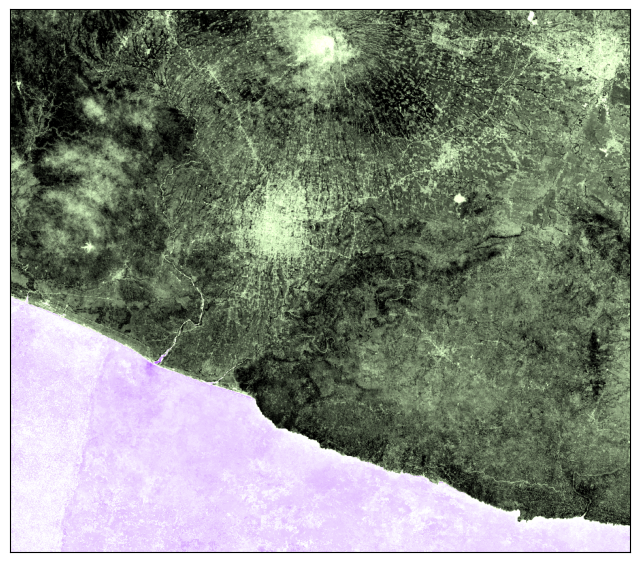

<Axes: >

In [ ]:
# Load image
image = rasterio.open(IMAGE_PATH)
# bandNum = image.count
height = image.height
width = image.width
# crs = image.crs
# transform = image.transform
shape = (height, width)

image_vis = []
for x in range(1, len(CLASSES)+1):
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

### Preprocessing

In [7]:
# Split data
X = df.drop(columns=['NDVI', 'label']) # hanya menggunakan B4 dan B8
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Label encoder
le = LabelEncoder()
le.fit(y_train)

y_train = le.fit_transform(y_train)
y_test  = le.fit_transform(y_test)

In [9]:
# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(np.array(X_train))
test_input = reshape_input(np.array(X_test))

# Also make label data to categorical
train_output = to_categorical(y_train, N_CLASSES + 1)
test_output = to_categorical(y_test, N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (7794, 2, 1)
Test features: (1949, 2, 1)
Train label: (7794, 4)
Test label: (1949, 4)


In [10]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 128
drop = 0.1
kernel = 1
pool = 1

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 3, kernel, activation='relu'),
  Conv1D(neuron * 3, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 3, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 128)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            16512     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 128)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 128)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 256)            33024     
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 256)            65792     
                                                        

In [11]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
model_path = PATH + 'cnn_model_2023.h5'
stop = [ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5)]

# Fit the model
history = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=4,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
1949/1949 [==============================] - ETA: 0s - loss: 1.1673 - accuracy: 0.6969
Epoch 1: val_accuracy improved from -inf to 0.82812, saving model to /content/drive/MyDrive/NDVI_export/cnn_model_2023.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1949/1949 [==============================] - 27s 13ms/step - loss: 1.1673 - accuracy: 0.6969 - val_loss: 0.4962 - val_accuracy: 0.8281
Epoch 2/100
1948/1949 [============================>.] - ETA: 0s - loss: 0.4860 - accuracy: 0.8121
Epoch 2: val_accuracy did not improve from 0.82812
1949/1949 [==============================] - 22s 11ms/step - loss: 0.4860 - accuracy: 0.8122 - val_loss: 0.4261 - val_accuracy: 0.8281
Epoch 3/100
1949/1949 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8182
Epoch 3: val_accuracy did not improve from 0.82812
1949/1949 [==============================] - 21s 11ms/step - loss: 0.4622 - accuracy: 0.8182 - val_loss: 0.4519 - val_accuracy: 0.8281
Epoch 4/100
1947/1949 [============================>.] - ETA: 0s - loss: 0.4457 - accuracy: 0.8222
Epoch 4: val_accuracy did not improve from 0.82812
1949/1949 [==============================] - 22s 11ms/step - loss: 0.4454 - accuracy: 0.8223 - val_loss: 0.4359 - val_accuracy: 0.8281
Epoch 5/10

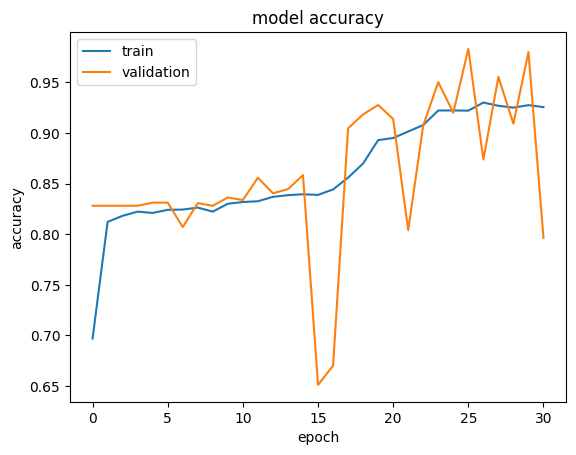

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

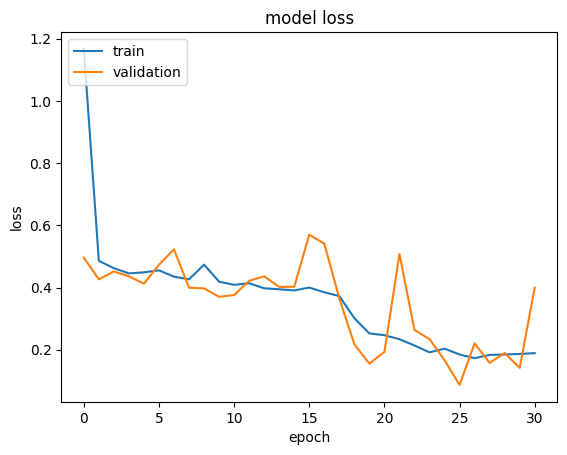

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
n_model = load_model(model_path)

# Predict test data
prediction = np.argmax(n_model.predict(test_input), 1).flatten()
label      = np.argmax(test_output, 1).flatten()

61/61 [==============================] - 1s 8ms/step


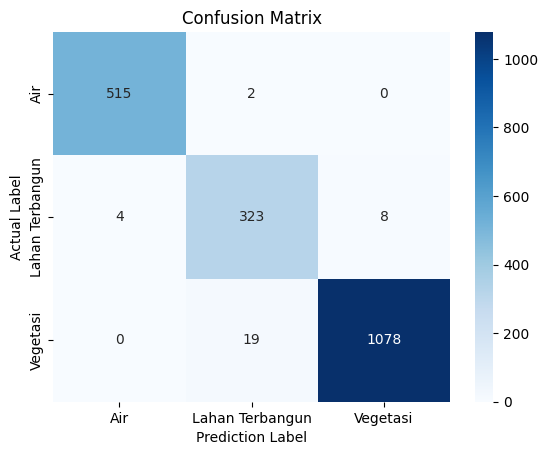

In [15]:
cm           = confusion_matrix(label, prediction)
df_confusion = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)

sns.heatmap(df_confusion, annot=True, fmt = "d", cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Prediction Label')
plt.ylabel('Actual Label')
plt.show()

In [16]:
accuracy_  = round(accuracy_score(label, prediction)*100, 2)
precision_ = round(precision_score(label, prediction, average='weighted')*100, 2)
recall_    = round(recall_score(label, prediction, average='weighted')*100, 2)
f1_score_  = round(f1_score(label, prediction, average='weighted')*100, 2)

print('Accuracy  : ', accuracy_)
print('Precision : ', precision_)
print('Recall    : ', recall_)
print('F1-score  : ', f1_score_)

Accuracy  :  98.31
Precision :  98.33
Recall    :  98.31
F1-score  :  98.31


In [17]:
new_input  = reshape_input(np.array(X))
prediction = np.argmax(model.predict(new_input), 1).flatten()

df['klasifikasi'] = le.inverse_transform(prediction)

# Hitung jumlah piksel untuk setiap kelas dari hasil klasifikasi
n_pixels_air = df[df['klasifikasi'] == 'air'].shape[0]
n_pixels_lahan_terbangun = df[df['klasifikasi'] == 'lahan terbangun'].shape[0]
n_pixels_vegetasi = df[df['klasifikasi'] == 'vegetasi'].shape[0]

# Resolusi piksel (dalam meter persegi)
resolution = 1000

# Konversi jumlah piksel menjadi luas dalam meter persegi
area_air = (n_pixels_air * resolution) / 1000000
area_lahan_terbangun = (n_pixels_lahan_terbangun * resolution) / 1000000
area_vegetasi = (n_pixels_vegetasi * resolution) / 1000000

# Print hasil luas
print("Luas Lahan Air:", area_air, "km2")
print("Luas Lahan Terbangun:", area_lahan_terbangun, "km2")
print("Luas Lahan Vegetasi:", area_vegetasi, "km2")

305/305 [==============================] - 3s 8ms/step
Luas Lahan Air: 3.367 km2
Luas Lahan Terbangun: 2.051 km2
Luas Lahan Vegetasi: 4.325 km2
